# Part 1: Decision Tree

In [7]:
import pandas as pd

data=pd.read_csv(r"C:\Users\50328\OneDrive\Documents\CS 677\Homework\assignment_10_decision_rf_tips\AAPL_Daily.csv",parse_dates=['Date'])
data.set_index('Date', inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,133.520004,133.610001,126.760002,129.410004,127.331703,143301900
2021-01-05,128.889999,131.740005,128.429993,131.009995,128.906006,97664900
2021-01-06,127.720001,131.050003,126.379997,126.599998,124.566818,155088000
2021-01-07,128.360001,131.630005,127.860001,130.919998,128.817459,109578200
2021-01-08,132.429993,132.630005,130.229996,132.050003,129.929291,105158200


In [11]:
# Resample data to weekly, taking the last 'Adj Close' of each week for label calculation
weekly_adj_close = data['Adj Close'].resample('W').last()

# Calculate weekly returns (1 if next week's close is higher, else 0)
weekly_returns = (weekly_adj_close.shift(-1) > weekly_adj_close).astype(int)

# Resample data to calculate mean (µ) and standard deviation (σ) for each week
# These values are calculated for the 'Adj Close' column
weekly_mean = data['Adj Close'].resample('W').mean()
weekly_std = data['Adj Close'].resample('W').std()

# Merge these values into the original dataframe
# Note: The weekly values will be repeated for days within the same week
data['Mean'] = weekly_mean.reindex(data.index, method='ffill')
data['Std'] = weekly_std.reindex(data.index, method='ffill')
data['Labels'] = weekly_returns.reindex(data.index, method='ffill')

# Drop the last week as it will not have a label (next week's data is not available)
data = data[:-1]

# Save the updated dataframe to a new CSV file
data.to_csv("AAPL_Updated_Daily.csv")

data.head()

,Open,High,Low,Close,Adj Close,Volume,Mean,Std,Labels
Date,,,,,,,,,
2021-01-04,133.520004,133.610001,126.760002,129.410004,127.331703,143301900,NaN,NaN,NaN
2021-01-05,128.889999,131.740005,128.429993,131.009995,128.906006,97664900,NaN,NaN,NaN
2021-01-06,127.720001,131.050003,126.379997,126.599998,124.566818,155088000,NaN,NaN,NaN
2021-01-07,128.360001,131.630005,127.860001,130.919998,128.817459,109578200,NaN,NaN,NaN
2021-01-08,132.429993,132.630005,130.229996,132.050003,129.929291,105158200,NaN,NaN,NaN


In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data into training (2021) and testing (2022)
train_data_weekly = data[data.index.year == 2021]
test_data_weekly = data[data.index.year == 2022]

# Remove rows with NaN labels from the training and testing sets
train_data_weekly = train_data_weekly.dropna(subset=['Labels'])
test_data_weekly = test_data_weekly.dropna(subset=['Labels'])

# Training and testing sets
X_train_weekly = train_data_weekly[['Mean', 'Std']]
y_train_weekly = train_data_weekly['Labels']
X_test_weekly = test_data_weekly[['Mean', 'Std']]
y_test_weekly = test_data_weekly['Labels']

# Initialize and train the decision tree classifier
clf_weekly = DecisionTreeClassifier(criterion='entropy')
clf_weekly.fit(X_train_weekly, y_train_weekly)

# Predictions for the test set
y_pred_weekly = clf_weekly.predict(X_test_weekly)

# Calculate accuracy
accuracy_weekly = accuracy_score(y_test_weekly, y_pred_weekly)

# Compute the confusion matrix
conf_matrix_weekly = confusion_matrix(y_test_weekly, y_pred_weekly)

# True Positive Rate (TPR) and True Negative Rate (TNR)
TPR_weekly = conf_matrix_weekly[1, 1] / (conf_matrix_weekly[1, 1] + conf_matrix_weekly[1, 0])  # TP / (TP + FN)
TNR_weekly = conf_matrix_weekly[0, 0] / (conf_matrix_weekly[0, 0] + conf_matrix_weekly[0, 1])  # TN / (TN + FP)

accuracy_weekly, conf_matrix_weekly, TPR_weekly, TNR_weekly

(0.44534412955465585,
 array([[67, 88],
        [49, 43]], dtype=int64),
 0.4673913043478261,
 0.432258064516129)

In [17]:
# Implement the trading strategy based on labels
def implement_strategy(data, labels):
    # Initial investment amount (can be any value, e.g., 1000)
    investment = 1000
    holding = False

    for i in range(len(data) - 1):
        if labels[i] == 1 and not holding:
            # Buy at the start of the week
            buy_price = data.iloc[i]
            holding = True
        elif holding:
            # Sell at the end of the week
            sell_price = data.iloc[i + 1]
            investment *= (sell_price / buy_price)
            holding = False

    # Sell any remaining holdings at the end of the year
    if holding:
        investment *= (data.iloc[-1] / buy_price)

    return investment

# Weekly Adj Close prices for 2022
weekly_adj_close_2022 = test_data_weekly['Adj Close'].resample('W').last().dropna()

# Labels for 2022
labels_2022 = y_pred_weekly

# Implement label-based strategy
investment_label_strategy = implement_strategy(weekly_adj_close_2022, labels_2022)

# Implement buy-and-hold strategy
buy_price = weekly_adj_close_2022.iloc[0]
sell_price = weekly_adj_close_2022.iloc[-1]
investment_buy_hold = 1000 * (sell_price / buy_price)

investment_label_strategy, investment_buy_hold

(853.2630715113818, 770.3158650213729)

# Part 2: Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# Split the data into training (2021) and testing (2022)
train_data_weekly = data[data.index.year == 2021]
test_data_weekly = data[data.index.year == 2022]

# Remove rows with NaN labels from the training and testing sets
train_data_weekly = train_data_weekly.dropna(subset=['Labels'])
test_data_weekly = test_data_weekly.dropna(subset=['Labels'])

# Training and testing sets
X_train = train_data_weekly[['Mean', 'Std']]
y_train = train_data_weekly['Labels']
X_test = test_data_weekly[['Mean', 'Std']]
y_test = test_data_weekly['Labels']

# Range of N (number of trees) and d (max depth)
N_values = range(1, 11)
d_values = range(1, 6)

# Store error rates for each combination of N and d
error_rates = {}

# Iterate over all combinations of N and d
for N in N_values:
    for d in d_values:
        # Initialize the Random Forest Classifier
        rf_clf = RandomForestClassifier(n_estimators=N, max_depth=d, criterion='entropy', random_state=0)
        
        # Train the classifier
        rf_clf.fit(X_train, y_train)

        # Predict on the test set
        y_pred = rf_clf.predict(X_test)

        # Calculate error rate
        error_rate = 1 - accuracy_score(y_test, y_pred)
        error_rates[(N, d)] = error_rate

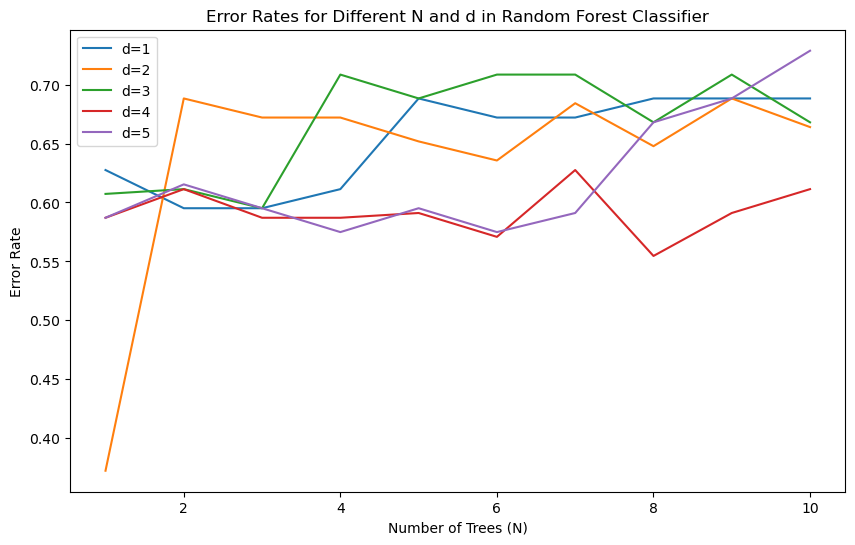

In [20]:
# Plotting the error rates
fig, ax = plt.subplots(figsize=(10, 6))
for d in d_values:
    ax.plot(N_values, [error_rates[(N, d)] for N in N_values], label=f'd={d}')

ax.set_xlabel('Number of Trees (N)')
ax.set_ylabel('Error Rate')
ax.set_title('Error Rates for Different N and d in Random Forest Classifier')
ax.legend()
plt.show()

In [21]:
# Find the combination of N and d with the lowest error rate
best_N_d = min(error_rates, key=error_rates.get)
best_N, best_d = best_N_d
best_error_rate = error_rates[best_N_d]

best_N_d, best_error_rate

((1, 2), 0.3724696356275303)

In [22]:
# Initialize the Random Forest Classifier with the optimal parameters
optimal_rf_clf = RandomForestClassifier(n_estimators=best_N, max_depth=best_d, criterion='entropy', random_state=0)

# Train the classifier using 2021 data
optimal_rf_clf.fit(X_train, y_train)

# Predict on the test set (2022 data)
y_pred_optimal = optimal_rf_clf.predict(X_test)

# Compute the confusion matrix
conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)

# Calculate TPR and TNR
TPR_optimal = conf_matrix_optimal[1, 1] / (conf_matrix_optimal[1, 1] + conf_matrix_optimal[1, 0])  # TP / (TP + FN)
TNR_optimal = conf_matrix_optimal[0, 0] / (conf_matrix_optimal[0, 0] + conf_matrix_optimal[0, 1])  # TN / (TN + FP)

conf_matrix_optimal, TPR_optimal, TNR_optimal

(array([[111,  44],
        [ 48,  44]], dtype=int64),
 0.4782608695652174,
 0.7161290322580646)

In [23]:
# Print the True Positive Rate and True Negative Rate
print(f"True Positive Rate (TPR) for Year 2: {TPR_optimal:.2f}")
print(f"True Negative Rate (TNR) for Year 2: {TNR_optimal:.2f}\n")

True Positive Rate (TPR) for Year 2: 0.48
True Negative Rate (TNR) for Year 2: 0.72



In [25]:
# Implement the trading strategy based on labels
def implement_strategy(data, labels):
    # Initial investment amount (can be any value, e.g., 1000)
    investment = 1000
    holding = False

    for i in range(len(data) - 1):
        if labels[i] == 1 and not holding:
            # Buy at the start of the week
            buy_price = data.iloc[i]
            holding = True
        elif holding:
            # Sell at the end of the week
            sell_price = data.iloc[i + 1]
            investment *= (sell_price / buy_price)
            holding = False

    # Sell any remaining holdings at the end of the year
    if holding:
        investment *= (data.iloc[-1] / buy_price)

    return investment

# Weekly Adj Close prices for 2022
weekly_adj_close_2022 = test_data_weekly['Adj Close'].resample('W').last().dropna()

# Implement label-based trading strategy for 2022
investment_label_strategy = implement_strategy(weekly_adj_close_2022, y_pred_optimal)

# Implement buy-and-hold strategy for 2022
investment_buy_hold = 1000 * (weekly_adj_close_2022.iloc[-1] / weekly_adj_close_2022.iloc[0])

# Print the results of the trading strategies
print("Comparison of Trading Strategies for Year 2:")
print(f"Label-Based Trading Strategy Return: ${investment_label_strategy:.2f}")
print(f"Buy-and-Hold Strategy Return: ${investment_buy_hold:.2f}\n")

# Compare which strategy resulted in a larger amount
if investment_label_strategy > investment_buy_hold:
    print("The Label-Based Trading Strategy resulted in a larger amount at the end of the year.")
else:
    print("The Buy-and-Hold Strategy resulted in a larger amount at the end of the year.")

Comparison of Trading Strategies for Year 2:
Label-Based Trading Strategy Return: $1000.00
Buy-and-Hold Strategy Return: $770.32

The Label-Based Trading Strategy resulted in a larger amount at the end of the year.


#  Part 3: AdaBoost

In [29]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define base estimators
base_estimators = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=1)
}

# Learning rates
learning_rates = [0.5, 1]

# Number of weak learners
N_values = range(1, 16)

# Store error rates for each combination of base estimator, learning rate, and N
error_rates = {estimator: {lr: [] for lr in learning_rates} for estimator in base_estimators}

C:\Users\50328\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\50328\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\50328\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\50328\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\50328\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\50328\anaconda3\Lib\site-p

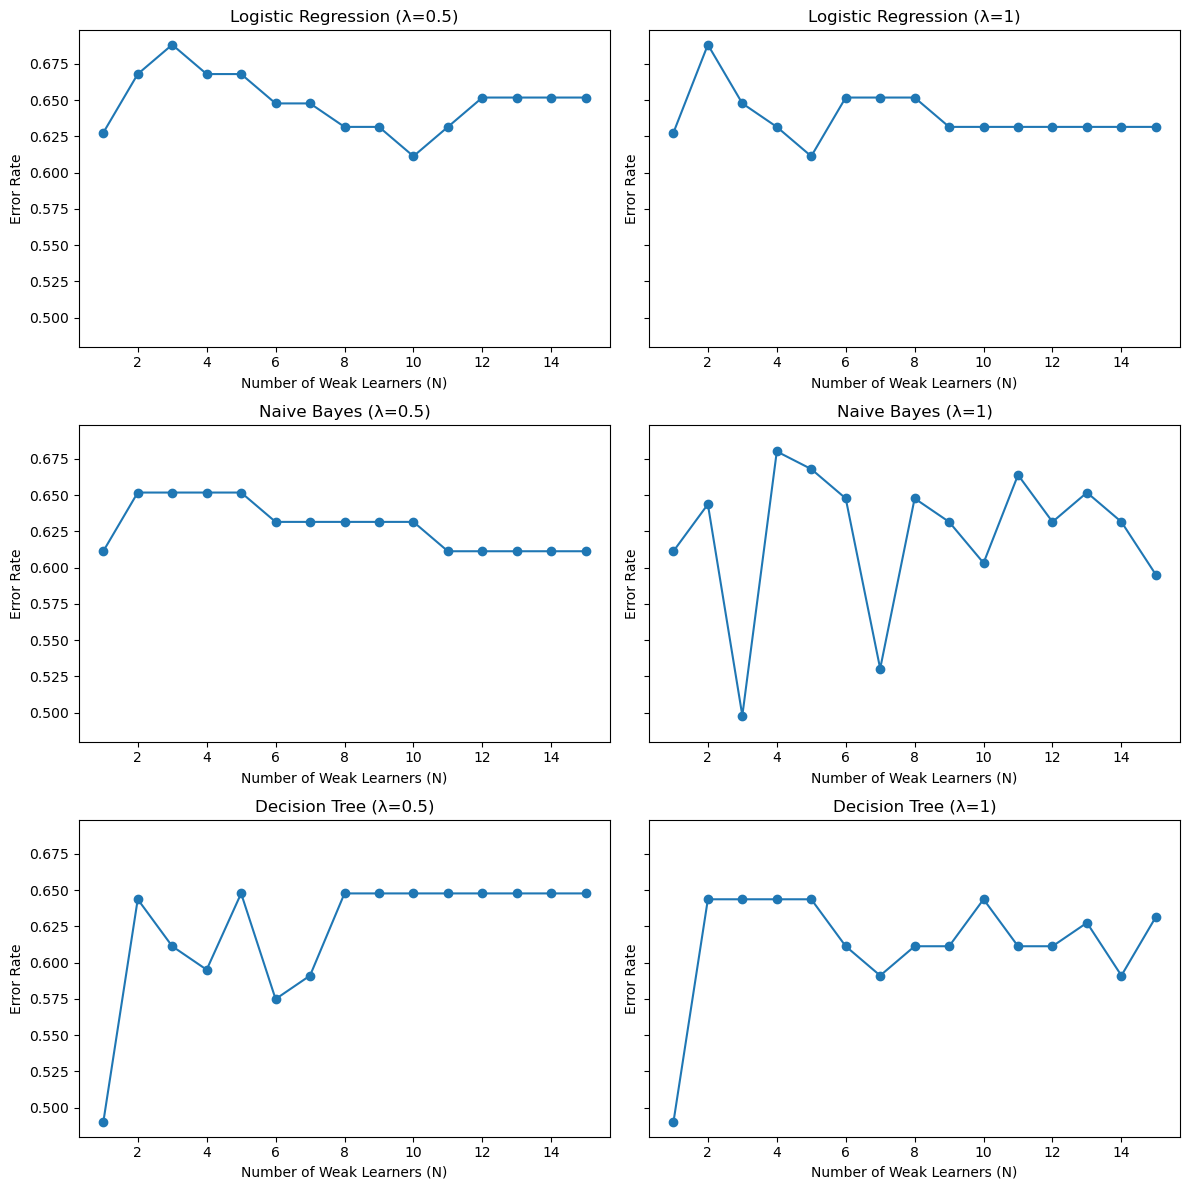

In [30]:
# Loop through each base estimator and learning rate
for estimator_name, base_estimator in base_estimators.items():
    for lr in learning_rates:
        for N in N_values:
            # Initialize AdaBoost Classifier
            ada_clf = AdaBoostClassifier(base_estimator=base_estimator, 
                                        n_estimators=N, 
                                        learning_rate=lr, 
                                        random_state=0)
            
            # Train the classifier using 2021 data
            ada_clf.fit(X_train, y_train)

            # Predict on the test set (2022 data)
            y_pred = ada_clf.predict(X_test)

            # Calculate error rate
            error_rate = 1 - accuracy_score(y_test, y_pred)
            error_rates[estimator_name][lr].append(error_rate)

# Plotting the error rates
fig, axes = plt.subplots(len(base_estimators), 2, figsize=(12, 12), sharey=True)
for i, estimator_name in enumerate(base_estimators):
    for j, lr in enumerate(learning_rates):
        axes[i, j].plot(N_values, error_rates[estimator_name][lr], marker='o')
        axes[i, j].set_title(f'{estimator_name} (λ={lr})')
        axes[i, j].set_xlabel('Number of Weak Learners (N)')
        axes[i, j].set_ylabel('Error Rate')

plt.tight_layout()
plt.show()

In [31]:
best_N_values = {}
for estimator_name in base_estimators:
    min_error_rate = min(error_rates[estimator_name][0.5])
    best_N = error_rates[estimator_name][0.5].index(min_error_rate) + 1  # Adding 1 because index starts from 0
    best_N_values[estimator_name] = best_N

best_N_values

{'Logistic Regression': 10, 'Naive Bayes': 1, 'Decision Tree': 1}

In [32]:
# Assume we have best_N_values which is a dictionary containing the best N for each base estimator
# Also assume error_rates contains the error rates for each base estimator and N value

# Calculate accuracy for each base estimator with its best N value
accuracies = {}
for estimator_name, best_N in best_N_values.items():
    # Initialize AdaBoost Classifier with the best N value for the current base estimator
    ada_clf_best = AdaBoostClassifier(base_estimator=base_estimators[estimator_name],
                                      n_estimators=best_N, learning_rate=0.5, random_state=0)
    ada_clf_best.fit(X_train, y_train)
    y_pred_best = ada_clf_best.predict(X_test)
    accuracies[estimator_name] = accuracy_score(y_test, y_pred_best)

# Determine the best base estimator
best_base_estimator_name = max(accuracies, key=accuracies.get)
best_base_estimator_accuracy = accuracies[best_base_estimator_name]

print("Accuracy for each base estimator with its best N value:")
for estimator, accuracy in accuracies.items():
    print(f"{estimator}: {accuracy:.2f}")

print(f"\nBest base estimator for AdaBoost: {best_base_estimator_name} with an accuracy of {best_base_estimator_accuracy:.2f}")

Accuracy for each base estimator with its best N value:
Logistic Regression: 0.39
Naive Bayes: 0.39
Decision Tree: 0.51

Best base estimator for AdaBoost: Decision Tree with an accuracy of 0.51


C:\Users\50328\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\50328\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\50328\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [33]:
# Initialize and train AdaBoost Classifier with the best base estimator
ada_clf_trading = AdaBoostClassifier(base_estimator=base_estimators[best_base_estimator_name],
                                     n_estimators=best_N_values[best_base_estimator_name], 
                                     learning_rate=0.5, random_state=0)
ada_clf_trading.fit(X_train, y_train)

# Predict labels for year 2 using the AdaBoost model
y_pred_trading = ada_clf_trading.predict(X_test_weekly)

# Implement label-based trading strategy for 2022
investment_label_strategy_ada = implement_strategy(weekly_adj_close_2022, y_pred_trading)  # assuming this function is defined as before

# Compare with buy-and-hold strategy for 2022
investment_buy_hold_ada = 1000 * (weekly_adj_close_2022.iloc[-1] / weekly_adj_close_2022.iloc[0])

print(f"Label-Based Trading Strategy Return with AdaBoost: ${investment_label_strategy_ada:.2f}")
print(f"Buy-and-Hold Strategy Return: ${investment_buy_hold_ada:.2f}\n")

# Determine which strategy resulted in a larger amount
if investment_label_strategy_ada > investment_buy_hold_ada:
    print("The Label-Based Trading Strategy with AdaBoost resulted in a larger amount at the end of the year.")
else:
    print("The Buy-and-Hold Strategy resulted in a larger amount at the end of the year.")

Label-Based Trading Strategy Return with AdaBoost: $1137.24
Buy-and-Hold Strategy Return: $770.32

The Label-Based Trading Strategy with AdaBoost resulted in a larger amount at the end of the year.


C:\Users\50328\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


#  Part 4: Tips

In [34]:
tips_data = pd.read_csv(r"C:\Users\50328\OneDrive\Documents\CS 677\Homework\assignment_10_decision_rf_tips\tips.csv")

In [35]:
# Question 1: Average Tip as a Percentage of Meal Cost for Lunch and Dinner

# Calculate tip percentage
tips_data['tip_percentage'] = (tips_data['tip'] / tips_data['total_bill']) * 100

# Calculate average tip percentage for lunch and dinner
average_tip_percentage = tips_data.groupby('time')['tip_percentage'].mean()

average_tip_percentage_lunch = average_tip_percentage.get('Lunch', 'No lunch data')
average_tip_percentage_dinner = average_tip_percentage.get('Dinner', 'No dinner data')

average_tip_percentage_lunch, average_tip_percentage_dinner

(16.412792816250498, 15.951778877977734)

In [36]:
# Question 2: Average Tip for Each Day of the Week as a Percentage of Meal Cost

average_tip_percentage_day = tips_data.groupby('day')['tip_percentage'].mean()
average_tip_percentage_day

day
Fri     16.991303
Sat     15.315172
Sun     16.689729
Thur    16.127563
Name: tip_percentage, dtype: float64

In [37]:
# Question 3: When Are Tips Highest (Which Day and Time)

# Group by both day and time, then find the maximum average tip percentage
highest_tip_day_time = tips_data.groupby(['day', 'time'])['tip_percentage'].mean().idxmax()
highest_average_tip = tips_data.groupby(['day', 'time'])['tip_percentage'].mean().max()

highest_tip_day_time, highest_average_tip

(('Fri', 'Lunch'), 18.876488829484337)

In [38]:
# Question 4: Correlation Between Meal Prices and Tips

correlation_meal_tip = tips_data['total_bill'].corr(tips_data['tip'])
correlation_meal_tip

0.6757341092113641

In [39]:
# Question 5: Relationship Between Tips and Size of the Group

correlation_tip_size = tips_data['size'].corr(tips_data['tip'])
correlation_tip_size

0.48929877523035775

In [40]:
# Question 6: Percentage of People Smoking

percentage_smokers = (tips_data['smoker'] == 'Yes').mean() * 100
percentage_smokers

38.114754098360656

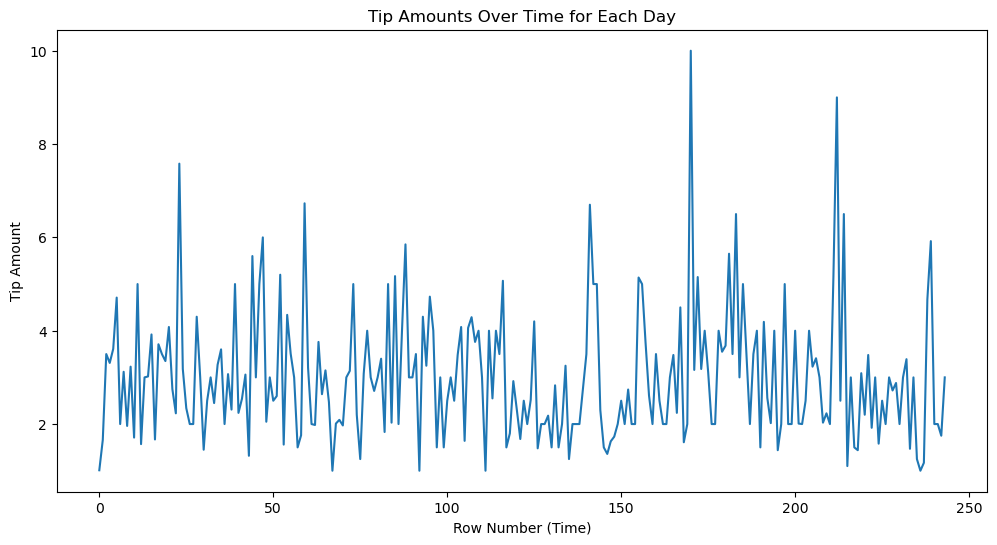

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Question 7: Are Tips Increasing with Time in Each Day?

# Assuming the rows in the dataset are arranged chronologically
# We'll plot tips for each day to visually inspect the trend

plt.figure(figsize=(12, 6))

# Plotting tips for each day
plt.plot(tips_data['tip'])

plt.xlabel('Row Number (Time)')
plt.ylabel('Tip Amount')
plt.title('Tip Amounts Over Time for Each Day')
plt.show()

In [47]:
# Calculate the correlation coefficient between tip amounts and smoker status (as a binary variable)
# Convert smoker status to a binary variable where 'Yes' is 1 and 'No' is 0
tips_data['smoker_binary'] = tips_data['smoker'].map({'Yes': 1, 'No': 0})

# Calculate the correlation coefficient
correlation_tip_smoker = tips_data['tip'].corr(tips_data['smoker_binary'])

correlation_tip_smoker

0.005928539527806581